# Check to see if there is any new data from my phone

In [42]:

import os
import shutil
# Define the source and destination directories
src_dir = "/run/user/1000/gvfs/mtp:host=motorola_motorola_one_5G_ace_ZY22DDHW4G/Internal shared storage/Download/Samsung Health"
dest_dir = "./data"

# Loop through all the directories in the source directory
for dir_name in os.listdir(src_dir):
    # Check if the item is a directory
    if os.path.isdir(os.path.join(src_dir, dir_name)):
        # Check if the directory already exists in the destination directory
        if not os.path.exists(os.path.join(dest_dir, dir_name)):
            # If it doesn't exist, copy it over
            shutil.copytree(os.path.join(src_dir, dir_name), os.path.join(dest_dir, dir_name))

In [44]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import numpy as np
dest_dir = "./data"
for dir_name in os.listdir(dest_dir):
    folder_dir = f"./data/{dir_name}/"

    # Do some cleaning on the folder data
    date_time_of_upload = folder_dir.split("_")[-1][:-1]

    # Rename all of the files so that they are easier to deal with
    for file_name in os.listdir(folder_dir):
        if os.path.isdir(folder_dir + file_name):
            continue
        if "com.samsung" not in file_name:
            continue
        new_file_name = file_name.replace(".".join(file_name.split(
            ".")[:3]) + ".", "").replace(date_time_of_upload + ".", "")
        os.rename(folder_dir + file_name, folder_dir + new_file_name)

    # Clean csv's so that they dont have that first line with junk
    for file_name in os.listdir(folder_dir):
        if os.path.isdir(folder_dir + file_name):
            continue
        file_text = ""
        with open(folder_dir + file_name, "r") as f:
            file_text = f.read()

            if "com.samsung" in (file_text.split("\n")[0]):
                file_text = "\n".join(file_text.split("\n")[1:])
                with open(folder_dir + file_name, "w") as f:
                    f.write(file_text)


In [53]:
# Most recent directory
folder_dir = "./data/"+os.listdir("./data")[-1] + "/"

# Helper functions

In [45]:

# datetime to time since last epoch
from datetime import datetime
import time

def convert_datetime_to_time_since_last_epoch(formatted_time):
    time_struct = time.strptime(formatted_time, "%Y-%m-%d %H:%M:%S.%f")
    datetime_obj = datetime.fromtimestamp(time.mktime(time_struct))
    return datetime_obj.timestamp()

formatted_time = "2023-08-15 12:34:56.789123"
timestamp = convert_datetime_to_time_since_last_epoch(formatted_time)

In [3]:
def apply_conversion_to_muliple_columns(dataframe, column_names, conversion: float):
    if type(conversion) == list:
        raise Exception("muliptle conversions not implemented yet")

    for column in column_names:
        dataframe[column] = dataframe[column].apply(lambda x: float(x) * conversion)
    return dataframe

# Weight

In [54]:
weight = pd.read_csv(folder_dir + "weight.csv", index_col=False)
# filter weight

weight = weight[weight["pkg_name"].isin(["cn.fitdays.fitdays"])]
weight = weight[pd.notna(weight["body_fat_mass"])]
weight["start_time"] = weight["start_time"].apply(convert_datetime_to_time_since_last_epoch)
weight = weight.rename(columns = {"total_body_water" : "water_mass"})
weight = apply_conversion_to_muliple_columns(weight, ["body_fat_mass", "weight", "muscle_mass", "skeletal_muscle_mass", "fat_free_mass", "water_mass"], 2.2)

# Convert weight to pounds

weight = weight.sort_values(by="start_time")
weight.drop(['custom', 'comment', "datauuid", "vfa_level", "deviceuuid", ], axis=1, inplace=True)
weight.head(5)

,body_fat_mass,start_time,height,weight,muscle_mass,update_time,create_time,skeletal_muscle,fat_free_mass,basal_metabolic_rate,time_offset,skeletal_muscle_mass,fat_free,pkg_name,body_fat,water_mass
95,58.835700,1.690311e+09,181.0,207.90,147.84,2023-07-26 01:29:51.438,2023-07-26 01:29:51.438,49.3,58.835700,2026.0,UTC-0500,102.494700,71.7,cn.fitdays.fitdays,28.3,102.74
57,60.151520,1.690392e+09,181.0,210.32,147.18,2023-07-26 17:31:18.204,2023-07-26 17:31:18.204,49.1,60.151520,2041.0,UTC-0500,103.267116,71.4,cn.fitdays.fitdays,28.6,103.40
19,59.753102,1.690392e+09,181.0,209.66,147.40,2023-07-26 17:31:18.226,2023-07-26 17:31:18.226,49.1,59.753102,2036.0,UTC-0500,102.943060,71.5,cn.fitdays.fitdays,28.5,103.18
38,58.172620,1.690568e+09,181.0,207.02,148.28,2023-07-28 13:20:03.899,2023-07-28 13:20:03.899,49.4,58.172620,2021.0,UTC-0500,102.267880,71.9,cn.fitdays.fitdays,28.1,102.30
96,57.513060,1.690654e+09,181.0,206.14,148.72,2023-07-29 13:07:37.314,2023-07-29 13:07:37.314,49.6,57.513060,2018.0,UTC-0500,102.245433,72.1,cn.fitdays.fitdays,27.9,102.30


muscle_mass  is  #40E0D0
weight  is  #4169E1
body_fat_mass  is  #32CD32
water_mass  is  #FF1493


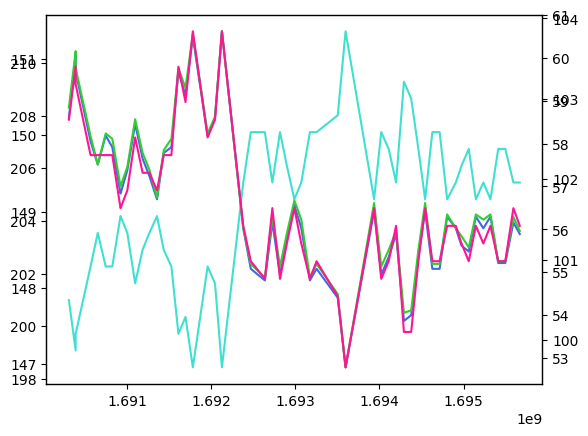

In [60]:
def plot_variables(df, x_axis_column_name, y_axis_column_names, y_axis_visible):
  assert len(y_axis_column_names) >= 2

  color_hex_codes = ['#FF5733', '#40E0D0', '#4169E1', '#32CD32', '#FFD700', '#DA70D6', '#FF7F50', '#708090', '#FF1493', '#008B8B']

  axes = []
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()

  axes = [ax1, ax2]

  if len(y_axis_column_names) > 2:
    for i in range(2, len(y_axis_column_names)):
      axes.append(axes[i % 2].twinx())
  else:
    # Label the axes with the two different column names
    axes[0].set_ylabel(y_axis_column_names[0])
    axes[1].set_ylabel(y_axis_column_names[1])
  
  for ax, column_name in zip(axes, y_axis_column_names):
    random.seed(42)
    color = random.choice(color_hex_codes)
    color_hex_codes.remove(color)
    print(column_name, " is ", color)
    ax.plot(df[x_axis_column_name], df[column_name], label=column_name, color=color)

    ax.get_yaxis().set_visible(y_axis_visible)
  plt.show()

plot_variables(weight, "start_time", ["muscle_mass", "weight", "body_fat_mass", "water_mass"], True)

## Sleep

In [139]:
def remove_columns(dataframe, columns):
  return dataframe.drop(columns=columns)

weekday_int_to_day = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
def convert_datetime_to_weekday(dataframe, column_name, weekday_int_to_day = False):
  if(weekday_int_to_day):
    dataframe["day_of_the_week"] = dataframe[column_name].apply(lambda x: weekday_int_to_day[datetime.fromtimestamp(x).weekday()])
  else:
    dataframe["day_of_the_week"] = dataframe[column_name].apply(lambda x: datetime.fromtimestamp(x).weekday())
  return dataframe

IndexError: single positional indexer is out-of-bounds

In [163]:

sleep = pd.read_csv(folder_dir + "sleep.csv", index_col=False)

columns_to_remove = ["comment", "datauuid", "custom","deviceuuid","pkg_name", "original_efficiency", "extra_data", "quality", "original_bed_time", "time_offset", "create_time", "update_time", "combined_id", "has_sleep_data", "sleep_type", "data_version"]
# Remove columns from sleep
# Define a lambda function to remove the prefix from column names

remove_prefix = lambda x: x.replace("com.samsung.health.sleep.", "")
# Rename the columns using the lambda function
sleep = sleep.rename(columns=remove_prefix)
sleep = sleep.drop(columns=columns_to_remove)
sleep["sleep_duration"] = sleep["sleep_duration"].apply(lambda x: float(x) / 60)
sleep["start_time"] = sleep["start_time"].apply(convert_datetime_to_time_since_last_epoch) - 9
sleep["end_time"] = sleep["end_time"].apply(convert_datetime_to_time_since_last_epoch) - 9
sleep = sleep.sort_values(by="start_time")
sleep = convert_datetime_to_weekday(dataframe=sleep, column_name="start_time")

# If there are multiple bouts of sleep that are close in time together (i.e. the endtime of one sleep is close to the start time of another sleep (less than 2 hours), then concatnate them into one bout of sleep and remove the previous 2)


# find the indexs when sleep_duration is nan
sleep = sleep[sleep.isna()["sleep_duration"] == False]

sleep.head(10)

,mental_recovery,factor_01,factor_02,factor_03,factor_04,factor_05,factor_06,factor_07,factor_08,factor_09,...,physical_recovery,original_wake_up_time,movement_awakening,sleep_cycle,efficiency,sleep_score,sleep_duration,start_time,end_time,day_of_the_week
0,84.0,30.0,49.0,9.0,6.0,29.0,453.0,144.0,0.0,3.0,...,64.0,NaN,13.0,4.0,93.0,80.0,7.550000,1.690276e+09,1.690303e+09,1
51,78.0,9.0,9.0,9.0,2.0,23.0,204.0,60.0,0.0,15.0,...,31.0,NaN,34.0,2.0,88.0,62.0,3.400000,1.690365e+09,1.690377e+09,2
3,73.0,0.0,11.0,14.0,2.0,44.0,200.0,99.0,0.0,31.0,...,26.0,NaN,52.0,1.0,78.0,58.0,3.333333,1.690378e+09,1.690390e+09,2
1,77.0,3.0,10.0,13.0,3.0,63.0,438.0,99.0,1.0,42.0,...,47.0,NaN,37.0,4.0,85.0,72.0,7.300000,1.690451e+09,1.690477e+09,3
2,49.0,36.0,36.0,11.0,21.0,59.0,537.0,128.0,3.0,27.0,...,72.0,NaN,25.0,6.0,89.0,60.0,8.950000,1.690533e+09,1.690566e+09,4
6,74.0,13.0,13.0,11.0,1.0,36.0,264.0,160.0,0.0,23.0,...,35.0,NaN,29.0,1.0,86.0,57.0,4.400000,1.690707e+09,1.690723e+09,6
5,63.0,8.0,11.0,3.0,7.0,43.0,263.0,63.0,1.0,31.0,...,36.0,NaN,33.0,2.0,83.0,56.0,4.383333,1.690724e+09,1.690740e+09,6
4,68.0,0.0,11.0,0.0,12.0,35.0,443.0,23.0,2.0,8.0,...,47.0,NaN,10.0,6.0,92.0,66.0,7.383333,1.690795e+09,1.690821e+09,0
8,82.0,7.0,28.0,6.0,8.0,42.0,442.0,59.0,1.0,22.0,...,55.0,NaN,25.0,6.0,90.0,72.0,7.366667,1.690878e+09,1.690904e+09,1
55,73.0,0.0,0.0,11.0,2.0,13.0,125.0,125.0,0.0,9.0,...,13.0,NaN,26.0,1.0,89.0,47.0,2.083333,1.690907e+09,1.690914e+09,1


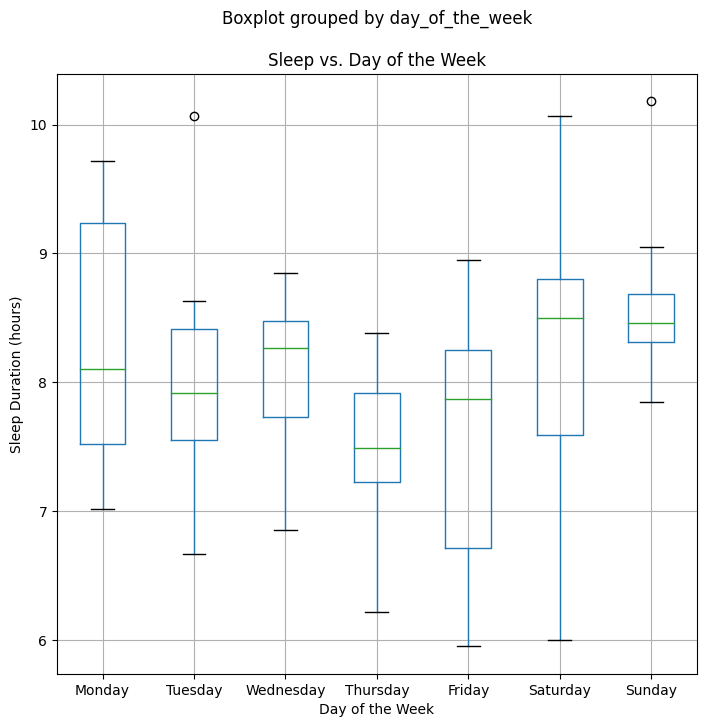

In [146]:
# Plot box and whisker chart for day of the week and amount slept

def plot_box_and_whisker(dataframe: pd.DataFrame, x_axis_column_name, y_axis_column_name):
  axes = dataframe.boxplot(column=y_axis_column_name, by=x_axis_column_name, return_type='axes', figsize=(8, 8))
  axes = (axes["sleep_duration"])
  
  axes.set_xlabel("Day of the Week")
  axes.set_ylabel("Sleep Duration (hours)")
  axes.set_title("Sleep vs. Day of the Week")

  # Get the current x-axis tick labels
  labels = axes.get_xticklabels()
  
  # Define the new x-axis tick labels
  new_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  
  # Set the new x-axis tick labels
  axes.set_xticklabels(new_labels)
  
  plt.show()

plot_box_and_whisker(sleep[sleep["sleep_duration"] > 5], "day_of_the_week", "sleep_duration")

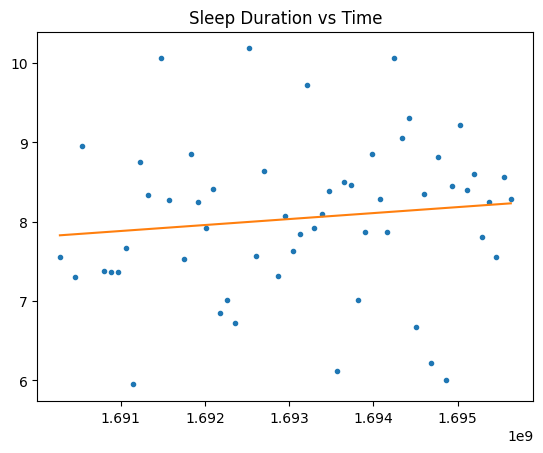

<Figure size 640x480 with 0 Axes>

In [149]:
# See how my sleep is changing

def plot_scatter(dataframe, x_axis_column_name, y_axis_column_name):
  dataframe.plot.scatter(x=x_axis_column_name, y=y_axis_column_name)
  plt.show()


# Plot the line of best fit for the data
def plot_line_of_best_fit(dataframe, x_axis_column_name, y_axis_column_name):
  x = dataframe[x_axis_column_name]
  y = dataframe[y_axis_column_name]
  m, b = np.polyfit(x, y, 1)
  plt.title("Sleep Duration vs Time")
  plt.plot(x, y, '.')
  plt.plot(x, m*x + b, '-')
  plt.show()
  plt.savefig("./figs/sleep_duration_vs_day_of_the_week_box_plot.png")
  
# plot_scatter(sleep, "com.samsung.health.sleep.start_time","sleep_duration")
plot_line_of_best_fit(sleep[sleep["sleep_duration"] > 5], "com.samsung.health.sleep.start_time","sleep_duration")